In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"
from skimage.measure import label

def clustertest(true,permutations,thresh):
    nperm = permutations.shape[-1]
    t_val = abs((true - np.mean(permutations,-1)) / np.std(permutations,-1)) # 2-sided
    above_threshold = t_val>thresh
    sig_clust = label(above_threshold)
    clust_sum = np.zeros(np.max(sig_clust))
    for c in range(1,max(sig_clust)+1):
        
        clust_sum[c-1] = np.sum(t_val[sig_clust==c])
    # get random clusters
    clust_sum_rand = np.zeros(nperm)
    for perm in range(nperm):
        compare_to = np.delete(permutations,perm,axis=-1)
        t_val = abs((permutations[:,perm] - np.mean(compare_to,-1)) / np.std(compare_to,-1))
        above_threshold = t_val>thresh
        sig_clust_rand = label(above_threshold)
        if np.max(sig_clust_rand)>0:
            clust_sum_r = np.zeros(np.max(sig_clust_rand))
            for c in range(1,max(sig_clust_rand)+1):
                clust_sum_r[c-1] = np.sum(t_val[sig_clust_rand==c])
            clust_sum_rand[perm] = np.max(clust_sum_r)
    # compard random and true
    P = np.zeros(true.shape)*np.nan
    for c in range(len(clust_sum)):
        P[sig_clust==c+1] = np.mean(clust_sum[c]<=clust_sum_rand)
    return P

Load preprocessed data and extract sequence variables

In [2]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe.pkl'%(animal_id)))

# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    
Session = np.concatenate([np.ones(len(Local[i]))*i for i in range(len(Local))])
Local = np.concatenate(Local)
Global = np.concatenate(Global)
Blocktype = np.concatenate(Blocktype)
Block = np.concatenate(Block)
Include = np.concatenate(Include)
StimID = np.concatenate(StimID)

['PFC_MU', 'PPC_MU', 'PFC_SU', 'PPC_SU', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']
Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


In [3]:
# time vectors
time_bins = np.load(os.path.join(out_path,'time_bins_gauss_%s.npy'%dates[0])) # time vector
time_bins_seq = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector
binsize = np.round(np.mean(np.diff(time_bins)),3)
time_bins = time_bins + binsize
time_bins_seq = time_bins_seq + binsize

In [9]:
# decoder performance
AUC_loc = np.load(os.path.join(out_path,'AUC_Local_last_True_classical_0.6.npy'))
AUC_glob = np.load(os.path.join(out_path,'AUC_Global_last_True_classical_0.6.npy'))
RandAUC_loc = np.load(os.path.join(out_path,'AUCRand_Local_last_classical_0.6.npy'))
RandAUC_glob = np.load(os.path.join(out_path,'AUCRand_Global_last_classical_0.6.npy'))
#AUC_stim = np.load(os.path.join(out_path,'AUC_Stim_first3_classical_600.npy'))
AUC_block = np.load(os.path.join(out_path,'AUC_Block_first3_classical_600.npy'))
#RandAUC_stim = np.load(os.path.join(out_path,'AUCRand_Stim_first3_classical_600.npy'))
RandAUC_block = np.load(os.path.join(out_path,'AUCRand_Block_first3_classical_600.npy'))

[array(['chair', 'teapot'], dtype=object), array(['bush', 'fish'], dtype=object), array(['blue', 'orange'], dtype=object), array(['chair', 'teapot'], dtype=object), array(['bird', 'bulldozer'], dtype=object), array(['bush', 'fish'], dtype=object)]


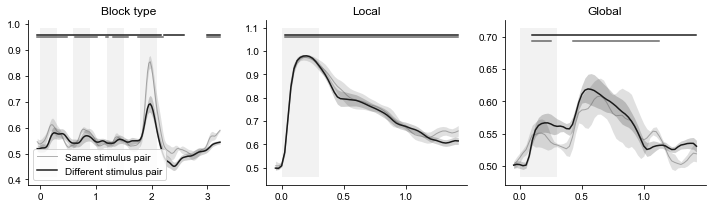

In [16]:
# get image identity per session
ImID = []
for d in dates:
    stim = np.unique(df.StimName[df.date==d])
    ImID.append(stim)
# for each session, get matching and non-matching stimulus days
match_days = []
nonmatch_days = []
print(ImID)
for sess in range(len(dates)):
    stim = ImID[sess]
    match = np.array([np.mean(i==stim) for i in ImID])
    match[sess] = np.nan
    match_days.append(np.where(match==1)[0])
    nonmatch_days.append(np.where(match==0)[0])

# plot sessions with match and non-match stim pair
# AUC for local, global and block type
AUC = [AUC_block,np.diagonal(AUC_loc[:,:,0,:],axis1=2,axis2=3),np.diagonal(AUC_glob[:,:,0,:],axis1=2,axis2=3)]
RandAUC = [RandAUC_block,RandAUC_loc[:,:,0,:],RandAUC_glob[:,:,0,:]]
Vars = ['Block type','Local','Global']
colors = np.array([[.4,.4,.4],[0.1,.1,.1]])
fig,ax = plt.subplots(1,len(AUC),figsize=(10,3))
nperm = RandAUC_loc.shape[-1]

threshold = 3
alpha = 0.05
soa = .6
binsize = np.round(np.mean(np.diff(time_bins)),3)
for v in range(len(AUC)):
    if Vars[v]=='Block type':
        t = time_bins_seq + binsize # shift by binsize
    else:
        t = time_bins + binsize
    # plot performance in sessions with same stimulus pair
    auc = np.zeros((len(dates),AUC[v].shape[-1]))*np.nan
    randauc = np.zeros((len(dates),AUC[v].shape[-1],nperm))*np.nan
    for sess in range(len(dates)):
        if len(match_days[sess])>0:
            auc[sess,:] = np.mean(AUC[v][match_days[sess],sess,:],0)
            randauc[sess,:] = np.mean(RandAUC[v][match_days[sess],sess,:],0)
    av = np.nanmean(auc,0)
    randav = np.nanmean(randauc,0)
    sem = np.nanstd(auc,0)/np.sqrt(sum(~np.isnan(auc[:,0])))
    ax[v].fill_between(t,av-sem,av+sem,color=colors[0],alpha=.2,linewidth=0)
    ax[v].plot(t,av,color=colors[0],alpha=.5,label='Same stimulus pair',linewidth=1)
    
    # stats:
    ymin,ymax = ax[v].get_ylim()
    p = clustertest(av,randav,threshold)
    l = label(~np.isnan(p))
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            ax[v].plot(t[l==j],np.ones(sum(l==j))*ymax+.05,color=colors[0],linewidth=1.5)
            
            
    # plot performance in sessions with different stimulus pair
    auc = np.zeros((len(dates),AUC[v].shape[-1]))*np.nan
    randauc = np.zeros((len(dates),AUC[v].shape[-1],nperm))*np.nan
    for sess in range(len(dates)):
        if len(nonmatch_days[sess])>0:
            auc[sess,:] = np.mean(AUC[v][nonmatch_days[sess],sess,:],0)
            randauc[sess,:] = np.mean(RandAUC[v][nonmatch_days[sess],sess,:],0)
    av = np.nanmean(auc,0)
    randav = np.nanmean(randauc,0)
    sem = np.nanstd(auc,0)/np.sqrt(sum(~np.isnan(auc[:,0])))
    ax[v].fill_between(t,av-sem,av+sem,color=colors[1],alpha=.2,linewidth=0)
    ax[v].plot(t,av,color=colors[1],label='Different stimulus pair')
    
    # stats:
    p = clustertest(av,randav,threshold)
    l = label(~np.isnan(p))
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            ax[v].plot(t[l==j],np.ones(sum(l==j))*ymax+.06,color=colors[1],linewidth=1.5)
            
    ax[v].set_title(Vars[v])
    
    # plot stimulus onsets
    ymin,ymax = ax[v].get_ylim()
    if Vars[v]=='Block type': 
        for i in range(4):
            ax[v].fill_between(np.linspace(i*soa,i*soa+soa/2,2),
                               np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
    else:
        ax[v].fill_between(np.linspace(0,soa/2,2),
                               np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
ax[0].legend()
plt.tight_layout()
sb.despine()
#plt.savefig(os.path.join(out_path,'plots','AUC_Generalization_%s_%s.pdf'%(exp,soa)))
plt.show()